<a href="https://colab.research.google.com/github/yahal2005/Facial-Emotion-Recognition/blob/main/facial_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install imbalanced-learn

In [67]:
from google.colab import drive
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, learning_curve, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import hog, local_binary_pattern
from sklearn.utils import shuffle
from collections import Counter
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [68]:
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/Colab_Notebooks/fer'
haarcascade_path = os.path.join(base_path, 'haarcascade_frontalface_default.xml')
face_cascade = cv2.CascadeClassifier(haarcascade_path)

ck_path = os.path.join(base_path, 'CK_dataset')
ck_train_p = os.path.join(ck_path, 'train')
ck_test_p = os.path.join(ck_path, 'test')

jaffe_path = os.path.join(base_path, 'JAFFE')
jaffe_train_p = os.path.join(jaffe_path, 'train')
jaffe_test_p = os.path.join(jaffe_path, 'test')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
def detect_and_crop_faces(folder_path,face_cascade,apply_blur=True):
    """
    Scans the folder, finds faces using Haar Cascade, crops them,
    optionally applies Gaussian Blur and resizes them to 64x64.
    Returns: Clean arrays of Face Images and Labels.
    """
    images = []
    labels = []


    if not os.path.exists(folder_path):
        print(f"Error: Folder not found: {folder_path}")
        return np.array([]), np.array([])

    print(f"Scanning & Detecting Faces")

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            count = 0
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img is not None:

                    # Detect Face
                    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

                    if len(faces) > 0:
                        # Crop the first face found
                        (x, y, w, h) = faces[0]
                        face_roi = img[y:y+h, x:x+w]
                        face_roi = clahe.apply(face_roi)

                        if apply_blur:
                            # Gentle blur to remove noise before HOG
                            face_roi = cv2.GaussianBlur(face_roi, (3, 3), 0)

                        # Resize to standard 64x64
                        face_roi = cv2.resize(face_roi, (64, 64))

                        images.append(face_roi)
                        labels.append(label)
                        count += 1
            print(f"     - Class '{label}': Found {count} faces.")

    return np.array(images), np.array(labels)

In [70]:
def augment_data(images, labels):
    """
    Doubles the data by flipping horizontally.
    ONLY run this on training data.
    """
    augmented_images = []
    augmented_labels = []

    print("   Augmenting data (Horizontal Flipping)...")
    for img, label in zip(images, labels):
        # 1. Original
        augmented_images.append(img)
        augmented_labels.append(label)

        # 2. Flipped (Augmentation)
        flipped = cv2.flip(img, 1)
        augmented_images.append(flipped)
        augmented_labels.append(label)

    print(f"   -> New size: {len(augmented_images)}")
    return np.array(augmented_images), np.array(augmented_labels)

In [71]:
def extract_hog_features(images):
    """
    Extracts  HOG (Shape) .
    """
    hog_features = []
    for img in images:
        # 1. HOG Feature (Shape)
        f_hog = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), block_norm='L2-Hys',
                    visualize=False, transform_sqrt=True)

        hog_features.append(f_hog)

    return np.array(hog_features)

In [72]:
def plot_confusion_matrix(labels_true, y_pred, title):
    """confusion matrix plotting function."""
    unique_labels = sorted(list(set(labels_true) | set(y_pred)))
    cm = confusion_matrix(labels_true, y_pred, labels=unique_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [73]:
def cross_evaluate(model, X_test, y_test, model_name, data_name):
    """
    Reuses evaluation logic for cross-dataset testing.
    """
    if model is None or X_test is None:
        print(f"Skipping {model_name} vs {data_name} (Model/Data missing)")
        return

    print(f"CROSS-TEST: {model_name} Model -> {data_name} Data")

    X_test = extract_hog_features(X_test)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Cross-Accuracy: {acc*100:.2f}%")
    print(classification_report(y_test, y_pred, zero_division=0))

    plot_confusion_matrix(y_test, y_pred, f"{model_name} Model on {data_name} Data")

In [74]:
def analyze_grid_results(grid, dataset_name):
    """
    1. Statistical Report.
    2. Adaptive Graph: Plots the most relevant parameter based on the kernel.
       - Linear -> Impact of C
       - Poly   -> Impact of Degree (or C)
       - RBF    -> Impact of Gamma
    """
    print(f"\n--- 📊 ANALYSIS: {dataset_name} Grid Search Results ---")

    results = pd.DataFrame(grid.cv_results_)
    best_row = results.loc[grid.best_index_]
    best_params = grid.best_params_
    best_kernel = best_params['kernel']

    print(f"Best Mean CV Accuracy: {best_row['mean_test_score']*100:.2f}%")
    print(f"Best Std Dev: {best_row['std_test_score']:.4f}")
    print(f"Best Params: {best_params}")

    plt.figure(figsize=(8, 4))

    # CASE 1: RBF (Plot Gamma)
    if best_kernel == 'rbf' and 'param_gamma' in results.columns:
        best_c = best_params['C']
        subset = results[(results['param_C'] == best_c) & (results['param_kernel'] == 'rbf')]

        plt.plot(subset['param_gamma'].astype(str), subset['mean_test_score'], 'o-', color='purple')
        plt.title(f'Impact of Gamma (RBF, Fixed C={best_c}) - {dataset_name}')
        plt.xlabel('Gamma')

    # CASE 2: LINEAR (Plot C)
    elif best_kernel == 'linear':
        subset = results[results['param_kernel'] == 'linear']

        plt.plot(subset['param_C'].astype(str), subset['mean_test_score'], 's-', color='blue')
        plt.title(f'Impact of C (Linear Kernel) - {dataset_name}')
        plt.xlabel('C (Regularization)')

    # CASE 3: POLY (Plot Degree or C)
    elif best_kernel == 'poly':
        # If we tuned degree, plot Degree. If degree was fixed, plot C.
        if 'param_degree' in results.columns and len(results['param_degree'].unique()) > 1:
            best_c = best_params['C']
            subset = results[(results['param_C'] == best_c) & (results['param_kernel'] == 'poly')]
            plt.plot(subset['param_degree'].astype(str), subset['mean_test_score'], '^--', color='orange')
            plt.title(f'Impact of Degree (Poly, Fixed C={best_c}) - {dataset_name}')
            plt.xlabel('Degree')
        else:
            # Fallback to plotting C if Degree was fixed
            subset = results[results['param_kernel'] == 'poly']
            plt.plot(subset['param_C'].astype(str), subset['mean_test_score'], '^--', color='orange')
            plt.title(f'Impact of C (Poly Kernel) - {dataset_name}')
            plt.xlabel('C (Regularization)')

    plt.ylabel('CV Accuracy')
    plt.grid(True)
    plt.show()

In [75]:
def generate_all_graphs(model, X_train, y_train, X_test, y_test, y_pred, X_img_test, dataset_name):
    """
    Generates:
    1. Misclassification Error Curve (Loss Proxy).
    2. Comparative Learning Curves (Linear vs Poly vs RBF).
    3. Confusion Matrix (Reuses helper).
    4. Sample Visual Predictions.
    """
    print(f"\n--- GENERATING GRAPHS: {dataset_name} ---")

    # --- GRAPH 1: LOSS CURVE (Misclassification Error) ---
    print("Generating Loss Proxy Curve...")
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
    )

    # Convert Accuracy to Error (Loss)
    train_loss = 1 - np.mean(train_scores, axis=1)
    test_loss = 1 - np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 5))
    plt.plot(train_sizes, train_loss, 'o-', color="#e74c3c", label="Training Error")
    plt.plot(train_sizes, test_loss, 'o-', color="#2ecc71", label="Validation Error")
    plt.fill_between(train_sizes, test_loss - test_std, test_loss + test_std, alpha=0.1, color="#2ecc71")
    plt.title(f'Figure 1: Misclassification Error Rate (Loss Proxy) - {dataset_name}')
    plt.xlabel('Training Examples')
    plt.ylabel('Error Rate (Lower is Better)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- GRAPH 2: COMPARATIVE KERNELS (Linear vs Poly vs RBF) ---
    print("Generating Comparative Kernel Curves...")

    # 1. Linear Curve
    linear_model = SVC(kernel='linear', C=1)
    _, _, test_scores_lin = learning_curve(
        linear_model, X_train, y_train, cv=3, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
    )
    linear_mean = np.mean(test_scores_lin, axis=1)

    # 2. Poly Curve (Degree 2)
    poly_model = SVC(kernel='poly', degree=2, C=1)
    _, _, test_scores_poly = learning_curve(
        poly_model, X_train, y_train, cv=3, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
    )
    poly_mean = np.mean(test_scores_poly, axis=1)

    # 3. RBF Curve (Best Model - Recalculated for alignment)
    _, _, test_scores_rbf = learning_curve(
        model, X_train, y_train, cv=3, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
    )
    rbf_mean = np.mean(test_scores_rbf, axis=1)

    plt.figure(figsize=(10, 5))
    plt.plot(train_sizes, linear_mean, 's--', color="blue", label="Linear")
    plt.plot(train_sizes, poly_mean, '^--', color="orange", label="Polynomial (d=2)")
    plt.plot(train_sizes, rbf_mean, 'o-', color="red", label="RBF (Best)")

    plt.title(f'Figure 2: Kernel Comparison - {dataset_name}')
    plt.xlabel('Training Examples')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


    # --- GRAPH 3: CONFUSION MATRIX (REUSING HELPER) ---
    plot_confusion_matrix(y_test, y_pred, f'Figure 3: Confusion Matrix - {dataset_name}')

    # --- GRAPH 4: SAMPLE PREDICTIONS ---
    print("Generating Visual Predictions...")
    selected_indices = []
    for label in np.unique(y_test):
        label_indices = np.where(y_test == label)[0]
        if len(label_indices) > 0:
            selected_indices.append(np.random.choice(label_indices))

    while len(selected_indices) < 5:
        rem = [i for i in range(len(y_test)) if i not in selected_indices]
        if not rem: break
        selected_indices.append(np.random.choice(rem))

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(selected_indices[:5]):
        img = X_img_test[idx]
        true_lbl = y_test[idx]
        pred_lbl = y_pred[idx]

        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap='gray')
        color = 'green' if true_lbl == pred_lbl else 'red'
        plt.title(f"True: {true_lbl}\nPred: {pred_lbl}", color=color)
        plt.axis('off')
    plt.suptitle(f'Figure 4: Sample Predictions - {dataset_name}')
    plt.show()

In [76]:
def train_pipeline(TRAIN_PATH, TEST_PATH, dataset_name,face_cascade, use_smote=False):
    """
    Main driver function.
    """
    print(f"PIPELINE START: {dataset_name} (SMOTE={use_smote})")


    # 1. Load & Preprocess
    images_train_raw, labels_train_raw = detect_and_crop_faces(TRAIN_PATH, face_cascade)
    images_test, labels_test = detect_and_crop_faces(TEST_PATH, face_cascade)

    if len(images_train_raw) == 0 or len(images_test) == 0:
        print("Error: Data not found.")
        return None, None, None, None

    # 2. Augment (Only Training Data)
    images_train, labels_train = augment_data(images_train_raw, labels_train_raw)

    # 3. Features
    print("--- Extracting HOG Features ---")
    images_train_hog = extract_hog_features(images_train)
    images_test_hog = extract_hog_features(images_test)

    # 4. SMOTE LOGIC
    if use_smote:
        print(f"--- Applying SMOTE (Before: {len(labels_train)}) ---")
        smote = SMOTE(random_state=42, k_neighbors=3)
        images_train_hog, labels_train = smote.fit_resample(images_train_hog, labels_train)
        print(f"--- SMOTE Complete (After: {len(labels_train)}) ---")

    # 5. Shuffle & CV Setup
    images_train_hog, labels_train = shuffle(images_train_hog, labels_train, random_state=42)

    # Dynamic Splits: Ensure we don't crash on small classes
    n_splits = min(5, max(2, min(Counter(labels_train).values())))

    # 6. Grid Search
    print(f"--- Training SVM (CV Splits: {n_splits}) ---")
    param_grid = [
        {'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']},
        {'C': [1, 10], 'kernel': ['linear']},
        {'C': [1, 10], 'degree': [2], 'kernel': ['poly']}
    ]

    svm = SVC(class_weight='balanced') if not use_smote else SVC()

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    grid = GridSearchCV(svm, param_grid, cv=cv, n_jobs=-1, verbose=1)
    grid.fit(images_train_hog, labels_train)

    best_model = grid.best_estimator_
    analyze_grid_results(grid, dataset_name)
    print(f"Best Params: {grid.best_params_}")

    # 7. Self-Evaluation
    y_pred = best_model.predict(images_test_hog)
    acc = accuracy_score(labels_test, y_pred)
    print(f"\n{dataset_name} Test Accuracy: {acc*100:.2f}%")
    print(classification_report(labels_test, y_pred, zero_division=0))

    generate_all_graphs(best_model, images_train_hog, labels_train, images_test_hog, labels_test, y_pred, images_test, dataset_name)

    return best_model, labels_test, images_test

>>> TRAINING (SMOTE DISABLED)
PIPELINE START: CK (SMOTE=False)
Scanning & Detecting Faces
     - Class 'fear': Found 16 faces.
     - Class 'happy': Found 75 faces.
     - Class 'neutral': Found 86 faces.
     - Class 'surprise': Found 82 faces.
     - Class 'angry': Found 40 faces.
     - Class 'sad': Found 41 faces.
Scanning & Detecting Faces
     - Class 'fear': Found 7 faces.
     - Class 'neutral': Found 36 faces.
     - Class 'happy': Found 30 faces.
     - Class 'surprise': Found 34 faces.
     - Class 'angry': Found 18 faces.
     - Class 'sad': Found 17 faces.
   Augmenting data (Horizontal Flipping)...
   -> New size: 680
--- Extracting HOG Features ---
--- Training SVM (CV Splits: 5) ---
Fitting 5 folds for each of 13 candidates, totalling 65 fits

--- 📊 ANALYSIS: CK Grid Search Results ---
Best Mean CV Accuracy: 69.56%
Best Std Dev: 0.0201
Best Params: {'C': 1, 'degree': 2, 'kernel': 'poly'}


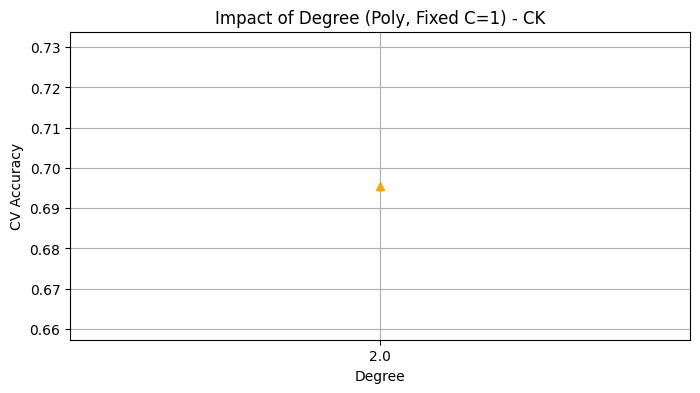

Best Params: {'C': 1, 'degree': 2, 'kernel': 'poly'}

CK Test Accuracy: 61.27%
              precision    recall  f1-score   support

       angry       0.62      0.44      0.52        18
        fear       0.00      0.00      0.00         7
       happy       0.90      0.87      0.88        30
     neutral       0.45      0.67      0.54        36
         sad       0.32      0.35      0.33        17
    surprise       0.92      0.68      0.78        34

    accuracy                           0.61       142
   macro avg       0.53      0.50      0.51       142
weighted avg       0.64      0.61      0.61       142


--- GENERATING GRAPHS: CK ---
Generating Loss Proxy Curve...


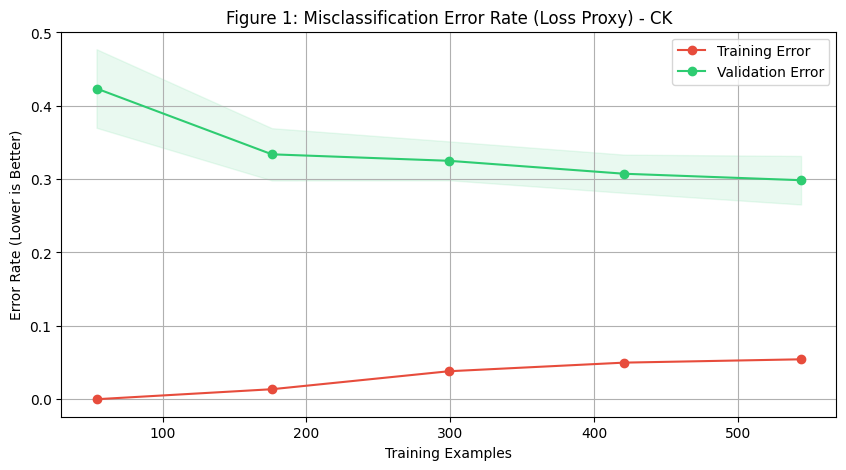

Generating Comparative Kernel Curves...


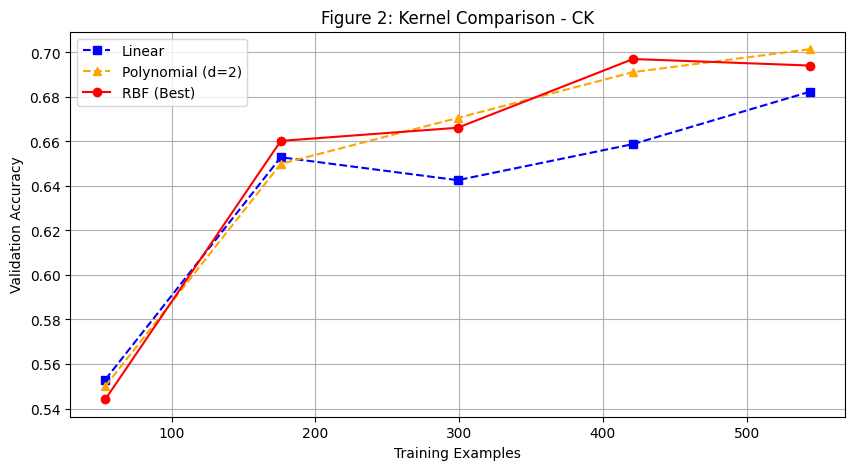

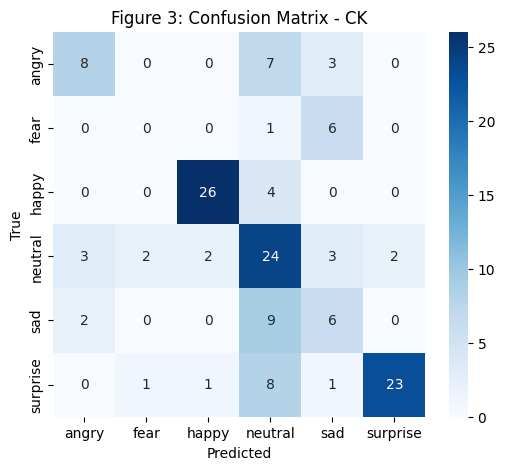

Generating Visual Predictions...


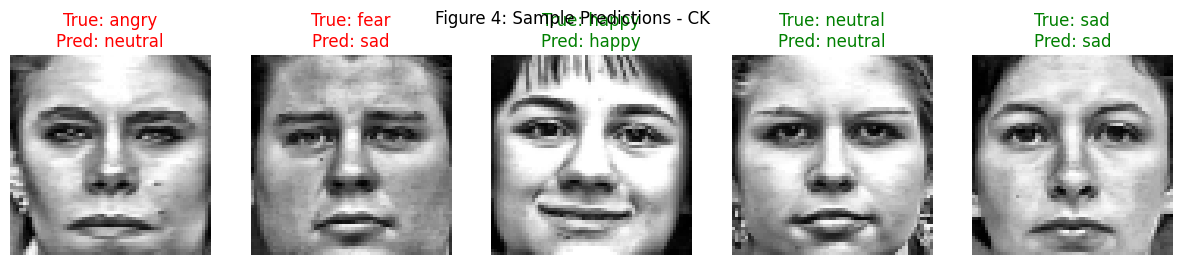

PIPELINE START: JAFFE (SMOTE=False)
Scanning & Detecting Faces
     - Class 'angry': Found 20 faces.
     - Class 'fear': Found 22 faces.
     - Class 'happy': Found 22 faces.
     - Class 'neutral': Found 21 faces.
     - Class 'sad': Found 22 faces.
     - Class 'surprise': Found 21 faces.
Scanning & Detecting Faces
     - Class 'angry': Found 9 faces.
     - Class 'fear': Found 10 faces.
     - Class 'happy': Found 9 faces.
     - Class 'neutral': Found 9 faces.
     - Class 'sad': Found 9 faces.
     - Class 'surprise': Found 9 faces.
   Augmenting data (Horizontal Flipping)...
   -> New size: 256
--- Extracting HOG Features ---
--- Training SVM (CV Splits: 5) ---
Fitting 5 folds for each of 13 candidates, totalling 65 fits

--- 📊 ANALYSIS: JAFFE Grid Search Results ---
Best Mean CV Accuracy: 93.35%
Best Std Dev: 0.0237
Best Params: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


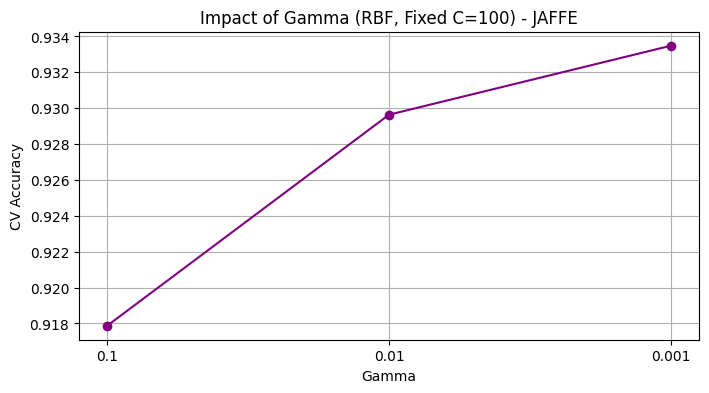

Best Params: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

JAFFE Test Accuracy: 87.27%
              precision    recall  f1-score   support

       angry       1.00      0.78      0.88         9
        fear       1.00      1.00      1.00        10
       happy       1.00      0.78      0.88         9
     neutral       0.69      1.00      0.82         9
         sad       0.75      1.00      0.86         9
    surprise       1.00      0.67      0.80         9

    accuracy                           0.87        55
   macro avg       0.91      0.87      0.87        55
weighted avg       0.91      0.87      0.87        55


--- GENERATING GRAPHS: JAFFE ---
Generating Loss Proxy Curve...


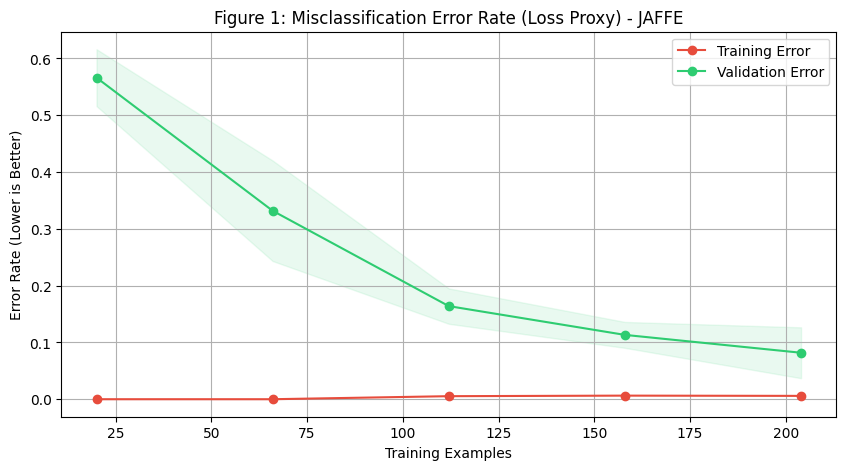

Generating Comparative Kernel Curves...


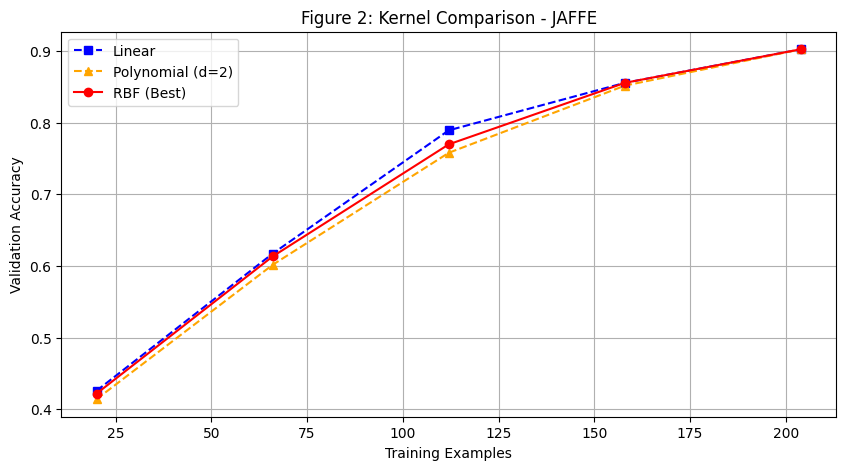

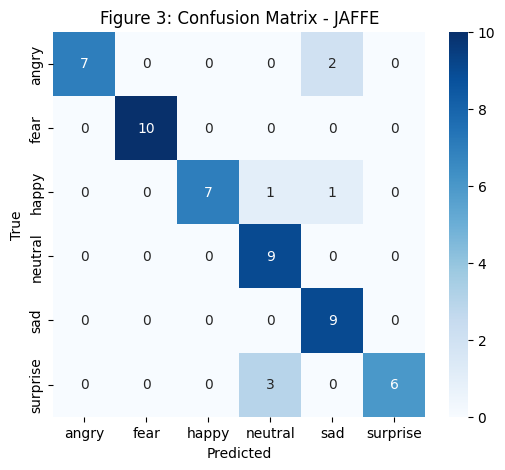

Generating Visual Predictions...


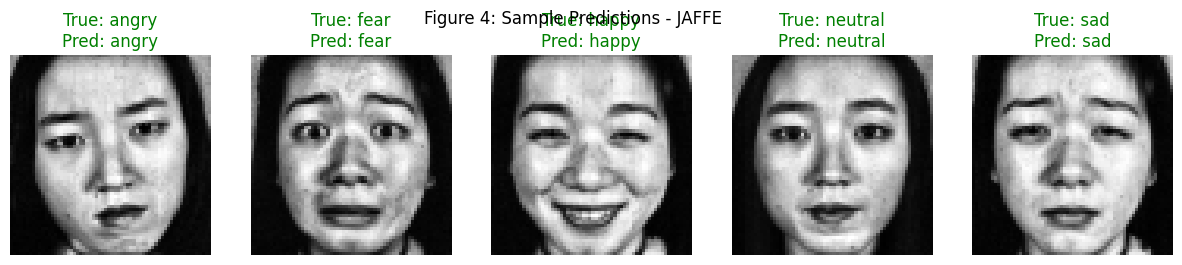

In [65]:
print(">>> TRAINING (SMOTE DISABLED)")
model_ck,  labels_test_ck, images_test_ck = train_pipeline(ck_train_p, ck_test_p, "CK", face_cascade)
model_jaffe,  labels_test_jaffe, images_test_jaffe = train_pipeline(jaffe_train_p, jaffe_test_p, "JAFFE",face_cascade)




>>> CROSS-EVALUATION
CROSS-TEST: CK Model -> JAFFE Data
Cross-Accuracy: 30.91%
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00         9
        fear       0.00      0.00      0.00        10
       happy       0.53      0.89      0.67         9
     neutral       0.00      0.00      0.00         9
         sad       0.00      0.00      0.00         9
    surprise       0.25      1.00      0.40         9

    accuracy                           0.31        55
   macro avg       0.13      0.31      0.18        55
weighted avg       0.13      0.31      0.17        55



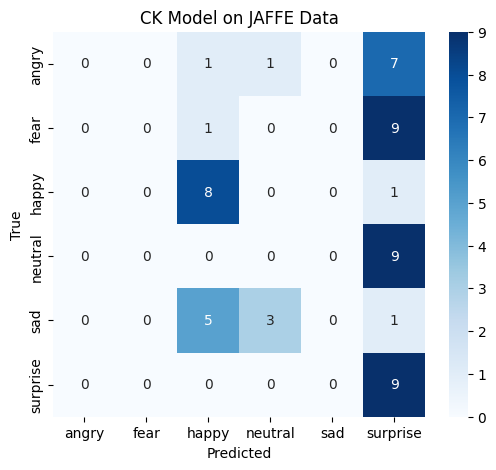

CROSS-TEST: JAFFE Model -> CK Data
Cross-Accuracy: 27.46%
              precision    recall  f1-score   support

       angry       0.16      0.83      0.27        18
        fear       0.29      0.57      0.38         7
       happy       0.83      0.50      0.62        30
     neutral       0.20      0.06      0.09        36
         sad       0.20      0.06      0.09        17
    surprise       1.00      0.06      0.11        34

    accuracy                           0.27       142
   macro avg       0.45      0.35      0.26       142
weighted avg       0.52      0.27      0.24       142



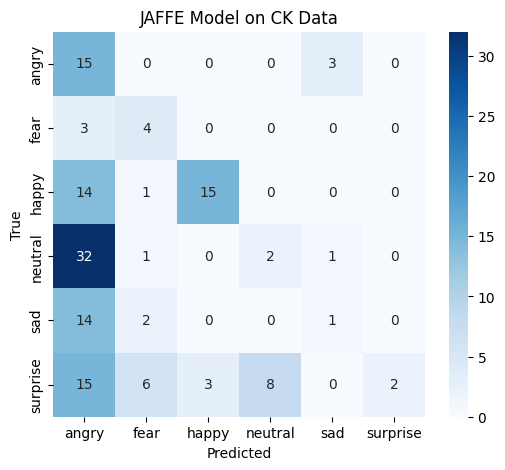

In [66]:
print("\n>>> CROSS-EVALUATION")
cross_evaluate(model_ck,images_test_jaffe, labels_test_jaffe, "CK", "JAFFE")
cross_evaluate(model_jaffe,images_test_ck, labels_test_ck, "JAFFE", "CK")

>>> TRAINING (SMOTE ENABLED)
PIPELINE START: CK (SMOTE=True)
Scanning & Detecting Faces
     - Class 'fear': Found 16 faces.
     - Class 'happy': Found 75 faces.
     - Class 'neutral': Found 86 faces.
     - Class 'surprise': Found 82 faces.
     - Class 'angry': Found 40 faces.
     - Class 'sad': Found 41 faces.
Scanning & Detecting Faces
     - Class 'fear': Found 7 faces.
     - Class 'neutral': Found 36 faces.
     - Class 'happy': Found 30 faces.
     - Class 'surprise': Found 34 faces.
     - Class 'angry': Found 18 faces.
     - Class 'sad': Found 17 faces.
   Augmenting data (Horizontal Flipping)...
   -> New size: 680
--- Extracting HOG Features ---
--- Applying SMOTE (Before: 680) ---
--- SMOTE Complete (After: 1032) ---
--- Training SVM (CV Splits: 5) ---
Fitting 5 folds for each of 13 candidates, totalling 65 fits

--- 📊 ANALYSIS: CK Grid Search Results ---
Best Mean CV Accuracy: 86.63%
Best Std Dev: 0.0180
Best Params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


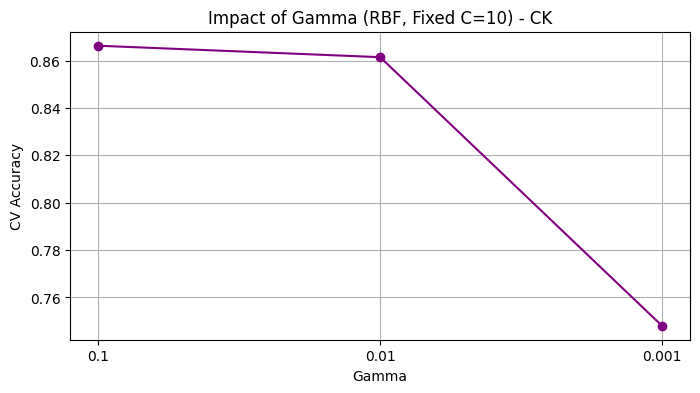

Best Params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

CK Test Accuracy: 64.08%
              precision    recall  f1-score   support

       angry       0.88      0.39      0.54        18
        fear       0.00      0.00      0.00         7
       happy       0.90      0.90      0.90        30
     neutral       0.44      0.72      0.55        36
         sad       0.38      0.29      0.33        17
    surprise       0.81      0.76      0.79        34

    accuracy                           0.64       142
   macro avg       0.57      0.51      0.52       142
weighted avg       0.65      0.64      0.63       142


--- GENERATING GRAPHS: CK ---
Generating Loss Proxy Curve...


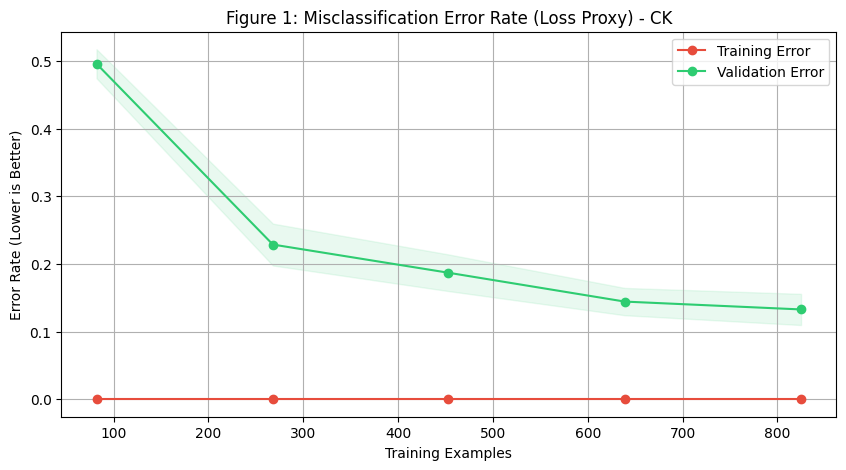

Generating Comparative Kernel Curves...


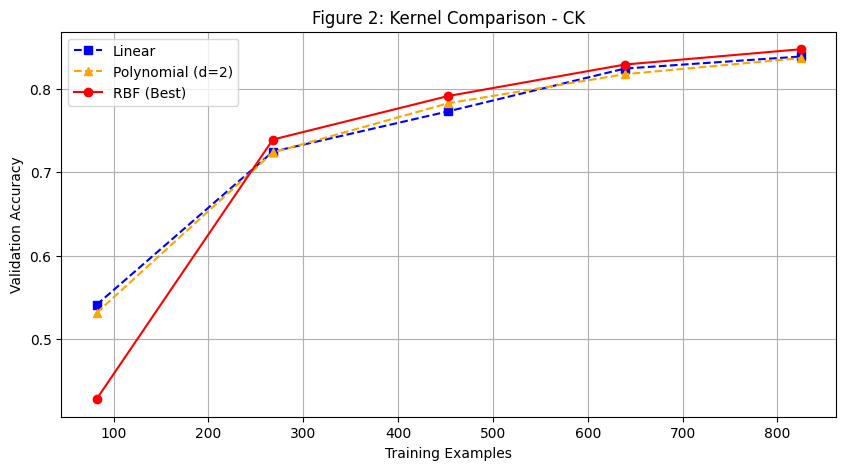

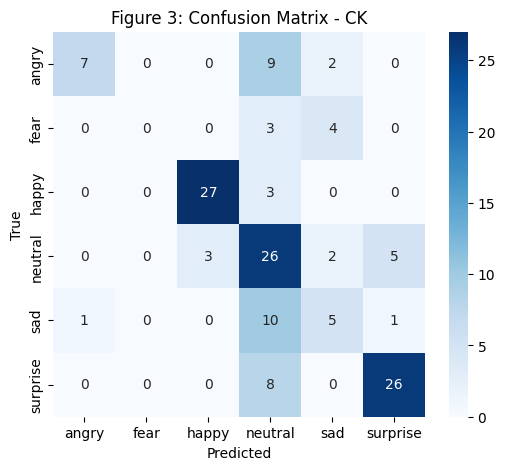

Generating Visual Predictions...


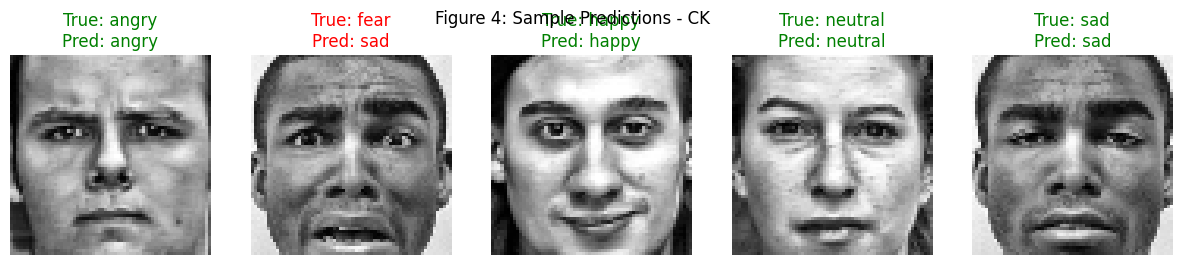

PIPELINE START: JAFFE (SMOTE=True)
Scanning & Detecting Faces
     - Class 'angry': Found 20 faces.
     - Class 'fear': Found 22 faces.
     - Class 'happy': Found 22 faces.
     - Class 'neutral': Found 21 faces.
     - Class 'sad': Found 22 faces.
     - Class 'surprise': Found 21 faces.
Scanning & Detecting Faces
     - Class 'angry': Found 9 faces.
     - Class 'fear': Found 10 faces.
     - Class 'happy': Found 9 faces.
     - Class 'neutral': Found 9 faces.
     - Class 'sad': Found 9 faces.
     - Class 'surprise': Found 9 faces.
   Augmenting data (Horizontal Flipping)...
   -> New size: 256
--- Extracting HOG Features ---
--- Applying SMOTE (Before: 256) ---
--- SMOTE Complete (After: 264) ---
--- Training SVM (CV Splits: 5) ---
Fitting 5 folds for each of 13 candidates, totalling 65 fits

--- 📊 ANALYSIS: JAFFE Grid Search Results ---
Best Mean CV Accuracy: 93.56%
Best Std Dev: 0.0306
Best Params: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


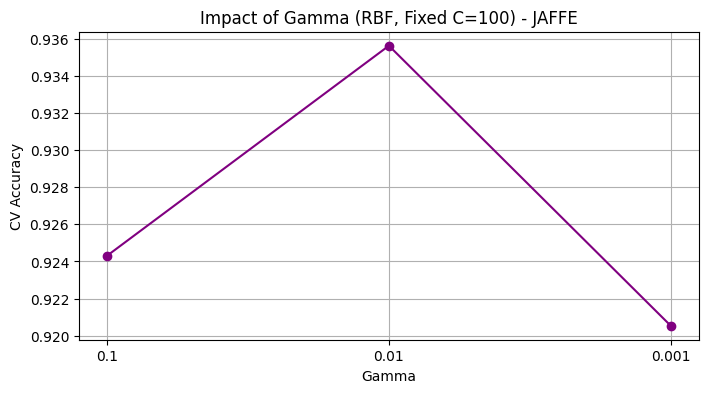

Best Params: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

JAFFE Test Accuracy: 85.45%
              precision    recall  f1-score   support

       angry       1.00      0.78      0.88         9
        fear       1.00      0.90      0.95        10
       happy       1.00      0.78      0.88         9
     neutral       0.69      1.00      0.82         9
         sad       0.69      1.00      0.82         9
    surprise       1.00      0.67      0.80         9

    accuracy                           0.85        55
   macro avg       0.90      0.85      0.86        55
weighted avg       0.90      0.85      0.86        55


--- GENERATING GRAPHS: JAFFE ---
Generating Loss Proxy Curve...


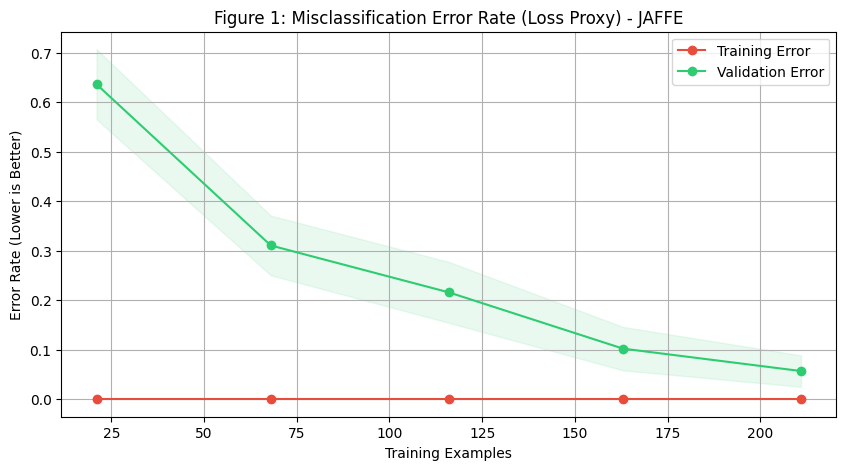

Generating Comparative Kernel Curves...


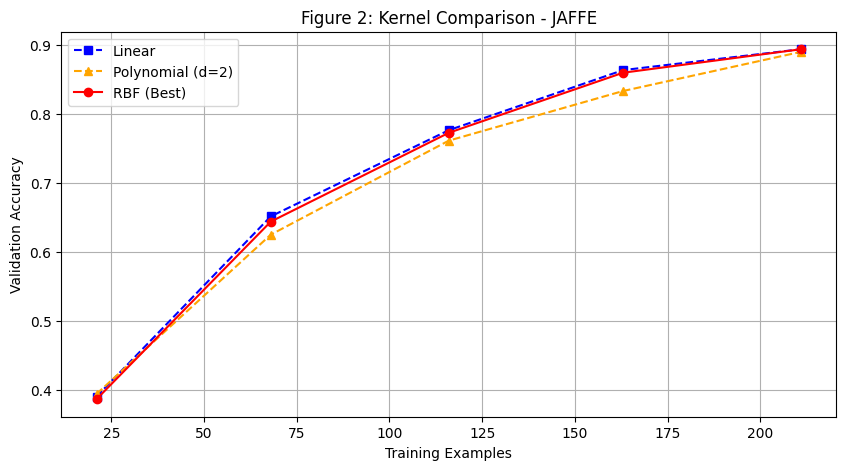

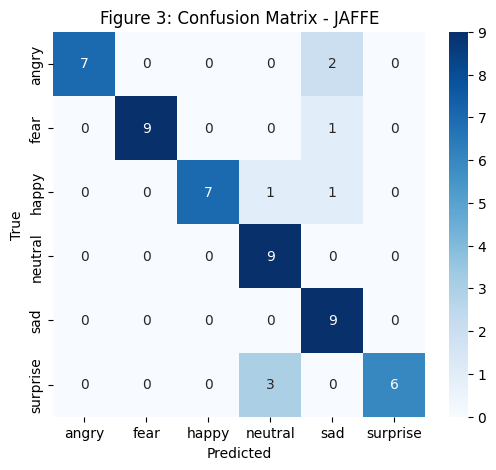

Generating Visual Predictions...


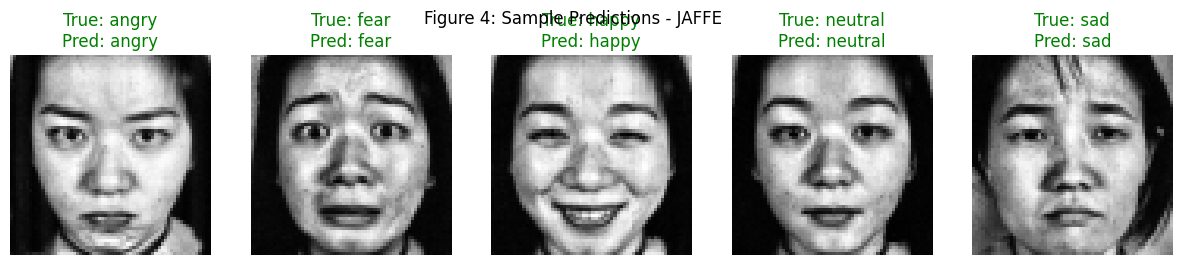


>>> CROSS-EVALUATION
CROSS-TEST: CK Model -> JAFFE Data
Cross-Accuracy: 25.45%
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00         9
        fear       0.00      0.00      0.00        10
       happy       1.00      0.56      0.71         9
     neutral       0.00      0.00      0.00         9
         sad       0.00      0.00      0.00         9
    surprise       0.20      1.00      0.33         9

    accuracy                           0.25        55
   macro avg       0.20      0.26      0.17        55
weighted avg       0.20      0.25      0.17        55



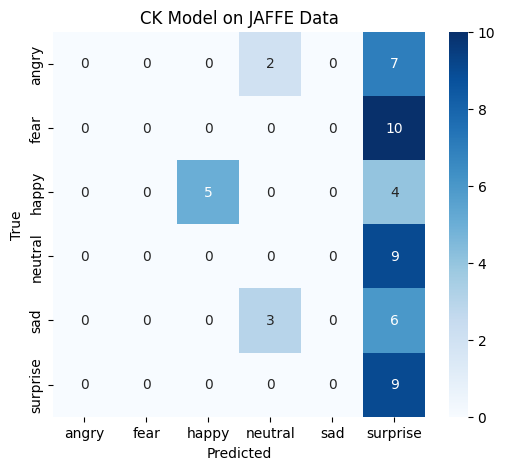

CROSS-TEST: JAFFE Model -> CK Data
Cross-Accuracy: 27.46%
              precision    recall  f1-score   support

       angry       0.16      0.83      0.27        18
        fear       0.24      0.57      0.33         7
       happy       0.88      0.47      0.61        30
     neutral       0.40      0.06      0.10        36
         sad       0.17      0.06      0.09        17
    surprise       1.00      0.09      0.16        34

    accuracy                           0.27       142
   macro avg       0.47      0.35      0.26       142
weighted avg       0.58      0.27      0.25       142



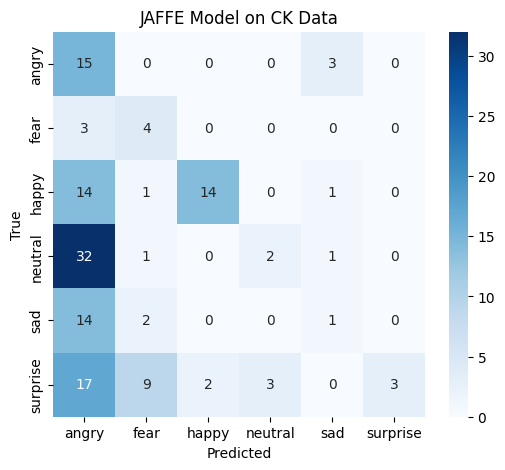

In [79]:
print(">>> TRAINING (SMOTE ENABLED)")
model_ck, labels_test_ck, images_test_ck = train_pipeline(ck_train_p, ck_test_p, "CK", face_cascade, use_smote=True)
model_jaffe,labels_test_jaffe , images_test_jaffe= train_pipeline(jaffe_train_p, jaffe_test_p, "JAFFE",face_cascade, use_smote=True)

print("\n>>> CROSS-EVALUATION")
cross_evaluate(model_ck, images_test_jaffe, labels_test_jaffe, "CK", "JAFFE")
cross_evaluate(model_jaffe, images_test_ck, labels_test_ck, "JAFFE", "CK")